In [140]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import os 
import networkx as nx
import igraph as ig
from ts2vg import NaturalVG
from scipy.spatial.distance import euclidean
from networkx import to_numpy_array

In [141]:
# data input

# load all timeseries in file
timeseries = []
datadir = "Data\PreviousData_v2\\"
for each in os.listdir("Data\PreviousData_v2"):
    timeseries.append(list(scipy.io.loadmat(datadir+each)["X"][0]))

# plt.plot(TS)

TIMESTEP = 150
OVERLAP = 135
TS = timeseries[0]
SEGMENTS = [TS[i:i+TIMESTEP] for i in range(0, len(TS)-TIMESTEP+1, TIMESTEP-OVERLAP)] #(from 0 to last possible timestep, in steps of len of timestep (remove overlap))
print("Generated " + str(len(SEGMENTS)) + " segments of length " + str(len(SEGMENTS[0])) + " with overlap of " + str(OVERLAP) + " in a timeseries of length " + str(len(timeseries[0])))


Generated 1219 segments of length 150 with overlap of 135 in a timeseries of length 18434


In [142]:
# builds natural visibility graph
vg = NaturalVG()
vg.build(TS[:1000])

import matplotlib.pyplot as plt
ig.plot(vg.as_igraph())
# plt.plot(TS[:1001])


In [143]:
# convert time series into natural visibility graphes
# https://github.com/CarlosBergillos/ts2vg

def construct_visibilty_graph(ts):
    # builds natural visibility graph
    vg = NaturalVG()
    vg.build(ts)
    # converts to networkx graph format
    g = vg.as_networkx()
    return g

def get_degree_sequence(vg):
    # get [(node, degrees),...] from a vg
    # convert to dict
    # get values (the degrees)
    ds = list(dict(nx.degree(vg)).values())
    return ds


(1219, 150)
(1219, 150)
(1219, 150)
(1219, 1219)
(1219, 1219)


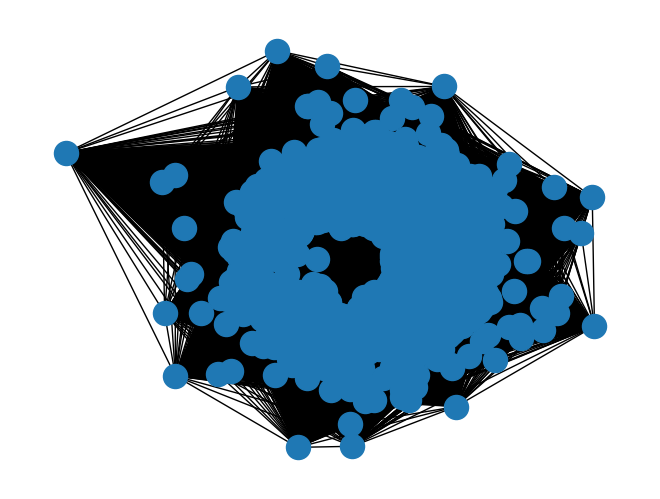

In [144]:
import numpy as np
import networkx as nx

# segment y_filtered into consecutive non-overlapping intervals
segments = [TS[i:i+TIMESTEP] for i in range(0, len(TS)-TIMESTEP+1, TIMESTEP-OVERLAP)]
print(np.array(segments).shape)

# construct a visibility graph for each segment
graphs = [construct_visibilty_graph(segment) for segment in segments]
print(np.array(graphs).shape)

# compute feature vectors for each graph using degree centrality
feature_vectors = [np.array(list(nx.degree_centrality(graph).values())) for graph in graphs]
print(np.array(feature_vectors).shape)

# define distance matrix D for each segment using Euclidean distance
distance_matrices = []
for i in range(len(feature_vectors)):
    D = np.zeros((len(feature_vectors), len(feature_vectors)))
    for j in range(len(feature_vectors)):
        D[i][j] = np.linalg.norm(feature_vectors[i]-feature_vectors[j])
    distance_matrices.append(D)

# compute global distance matrix by averaging distances across all segments
global_distance_matrix = np.mean(distance_matrices, axis=0)
print(np.array(global_distance_matrix).shape)

# normalize global distance matrix between 0 and 1
normalized_distance_matrix = 1 - (global_distance_matrix - np.min(global_distance_matrix)) / (np.max(global_distance_matrix) - np.min(global_distance_matrix))
print(np.array(normalized_distance_matrix).shape)

# construct weighted graph C using normalized distance matrix as adjacency matrix
# threshold = 0.0  # set a threshold to remove weak edges
# C = nx.from_numpy_array(normalized_distance_matrix * (normalized_distance_matrix >= threshold))

C = nx.from_numpy_array(normalized_distance_matrix)

# Set edge weights to similarity values
for u, v, d in C.edges(data=True):
    d['weight'] = normalized_distance_matrix[u][v]
    
# Remove self-loops
C.remove_edges_from(nx.selfloop_edges(C))

weightedGraph = C

# Draw the weighted graph
nx.draw(C)


{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 3, 24: 0, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 47: 2, 48: 2, 49: 2, 50: 2, 51: 2, 52: 2, 53: 2, 54: 2, 55: 2, 56: 2, 57: 2, 58: 2, 59: 2, 60: 2, 61: 2, 62: 2, 63: 2, 64: 2, 65: 2, 66: 2, 67: 0, 68: 0, 69: 0, 70: 0, 71: 3, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 2, 82: 2, 83: 2, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 2, 99: 2, 100: 2, 101: 2, 102: 2, 103: 2, 104: 2, 105: 2, 106: 2, 107: 2, 108: 2, 109: 2, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 

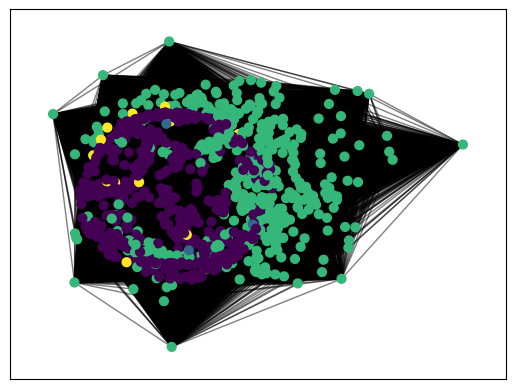

In [152]:
# community detection (clustering) of weighted graphes
# https://github.com/taynaud/python-louvain

# To achieve a modular visualization of the clusters detected by the discussed method and their
# mutual connections, we used a force-directed algorithm, namely the Frushterman–Reingold layout,
# as a graphical representation.
# Finally, for specific unsupervised FSS purposes, we considered a representative parameter for
# each cluster. Such parameters were identified based on their importance within the communities,
# by considering the signals with highest total degree centrality in their respective groups.

from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

partition = community_louvain.best_partition(weightedGraph, resolution=(1.01))

print(partition)

# draw the graph
pos = nx.spring_layout(weightedGraph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(weightedGraph, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(weightedGraph, pos, alpha=0.5)
plt.show()


{0, 1, 2, 3}


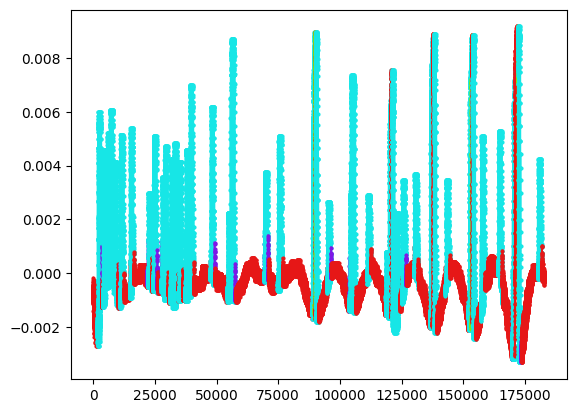

In [153]:
import matplotlib.pyplot as plt
print(set(list(partition.values())))

import colorsys
n_colors = len(set(list(partition.values())))  # number of colors to generate
colors = {}
for i in range(n_colors): # generates highly contrasting colors by incrementing hue
    hue = i / float(n_colors)
    saturation = 0.9
    value = 0.9
    (r, g, b) = colorsys.hsv_to_rgb(hue, saturation, value)
    colors[i] = (r, g, b)

# each timestep section assigned color of respective partition
for i in range(len(SEGMENTS)):
    plt.plot(range(TIMESTEP*i, TIMESTEP*(i+1)), SEGMENTS[i], marker='o', markersize=2, color=colors[partition[i]])

plt.show()


In [154]:
# pruning of graphes
# perform edge pruning by filtering the pairwise similarities lower than the second quantile of their probability distribution